huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Using device: cuda


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

/tmp/ipykernel_31/632930928.py:78: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/1:   0%|                                                            | 0/196 [00:00<?, ?it/s]/tmp/ipykernel_31/632930928.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/1: 100%|██████████████████████████████████████| 196/196 [02:32<00:00,  1.29it/s, loss=0.296]
/tmp/ipykernel_31/632930928.py:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


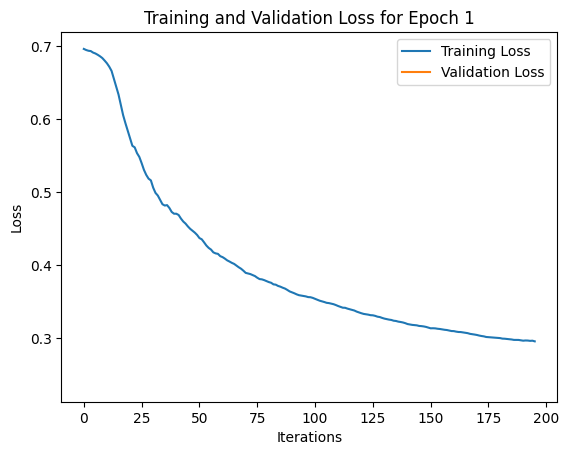

Epoch 1/1 - Train Loss: 0.2956 - Validation Loss: 0.2359
Prediction for sample text: positive


/tmp/ipykernel_31/632930928.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


In [10]:
# Install necessary libraries
!pip install transformers datasets -q
import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load the IMDB dataset
dataset = load_dataset("imdb")

# Use the test set as the validation set
train_data = dataset["train"]
val_data = dataset["test"]

# Tokenizing the training and validation data
model_name = "distilroberta-base"  # Use smaller model for efficiency
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

# Apply tokenization
train_data = train_data.map(tokenize_function, batched=True)
val_data = val_data.map(tokenize_function, batched=True)

# Convert datasets to PyTorch tensors and create DataLoaders
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=256, shuffle=False, pin_memory=True)

# Define the Mixture of Experts model
class MoEClassifier(nn.Module):
    def __init__(self, base_model_name="distilroberta-base", num_labels=2, num_experts=3):
        super(MoEClassifier, self).__init__()
        # Base transformer model (without classification head)
        self.base_model = AutoModel.from_pretrained(base_model_name)
        self.hidden_size = self.base_model.config.hidden_size
        self.num_labels = num_labels
        self.num_experts = num_experts
        # Expert heads (each a simple linear classifier)
        self.experts = nn.ModuleList([nn.Linear(self.hidden_size, self.num_labels) for _ in range(num_experts)])
        # Gating network that produces weights for each expert
        self.gate = nn.Linear(self.hidden_size, self.num_experts)

    def forward(self, input_ids, attention_mask, labels=None):
        # Transformer forward pass
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        # Use [CLS] token representation (first token) as pooled output
        last_hidden_state = outputs.last_hidden_state  # (batch_size, seq_len, hidden_size)
        pooled_output = last_hidden_state[:, 0, :]  # (batch_size, hidden_size)
        # Compute gating weights (softmax over experts)
        gating_logits = self.gate(pooled_output)  # (batch_size, num_experts)
        gating_weights = torch.softmax(gating_logits, dim=1)  # (batch_size, num_experts)
        # Compute each expert's logits
        expert_logits = torch.stack([expert(pooled_output) for expert in self.experts], dim=1)  # (batch_size, num_experts, num_labels)
        # Combine experts' outputs weighted by gating probabilities
        weighted_logits = expert_logits * gating_weights.unsqueeze(2)  # (batch_size, num_experts, num_labels)
        final_logits = weighted_logits.sum(dim=1)  # (batch_size, num_labels)
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(final_logits, labels)
        # Return a dict similar to HuggingFace model outputs
        return {"loss": loss, "logits": final_logits} if loss is not None else {"logits": final_logits}

# Initialize model, optimizer, and mixed precision scaler
num_experts = 3
model = MoEClassifier(base_model_name=model_name, num_experts=num_experts).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scaler = torch.cuda.amp.GradScaler()

# Initialize lists to track losses for plotting
train_losses = []
val_losses = []

# Training loop with live plot for loss (both training and validation)
epochs = 1
for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", ncols=100, position=0, leave=True)
    
    for batch in progress_bar:
        # Move data to device
        input_ids = batch["input_ids"].to(device, non_blocking=True)
        attention_mask = batch["attention_mask"].to(device, non_blocking=True)
        labels = batch["label"].to(device, non_blocking=True)
        optimizer.zero_grad()
        
        # Forward pass with mixed precision
        with torch.cuda.amp.autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs["loss"]
        
        # Backward pass and optimization
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_train_loss += loss.item()
        
        # Update progress bar with the current loss
        progress_bar.set_postfix(loss=total_train_loss / (progress_bar.n + 1))
        
        # Track training loss for live plotting
        train_losses.append(total_train_loss / (progress_bar.n + 1))

    # Calculate average training loss
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Now evaluate on the validation set
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch["input_ids"].to(device, non_blocking=True)
            attention_mask = batch["attention_mask"].to(device, non_blocking=True)
            labels = batch["label"].to(device, non_blocking=True)
            
            # Forward pass with mixed precision
            with torch.cuda.amp.autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs["loss"]
            
            total_val_loss += loss.item()

    # Calculate average validation loss
    avg_val_loss = total_val_loss / len(val_dataloader)

    # Track validation loss for live plotting
    val_losses.append(avg_val_loss)

    # Plot live loss graph (training and validation losses)
    plt.clf()  # Clear the figure
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation Loss for Epoch {epoch+1}")
    plt.legend()
    plt.pause(0.1)  # Pause to update the plot

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Validation Loss: {avg_val_loss:.4f}")

# Show the final plot after training
plt.show()


# Inference function to classify new text
def infer(text):
    model.eval()
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=256).to(device)
    
    # Forward pass with mixed precision
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
            logits = outputs["logits"]
    
    # Get the predicted class (0 = negative, 1 = positive)
    prediction = torch.argmax(logits, dim=1).item()
    return "positive" if prediction == 1 else "negative"

# Example inference
sample_text = "I love this movie! It was amazing."
prediction = infer(sample_text)
print(f"Prediction for sample text: {prediction}")



In [11]:
import torch
import torch.nn.functional as F

def infer(model, input_data):
    """
    Perform inference with a Mixture-of-Experts model, returning detailed outputs and explanation.
    
    Args:
        model: The MoE model (with a gating network and multiple expert submodels).
        input_data: The input sample (already preprocessed as needed for the model).
    
    Returns:
        A dictionary with keys:
          - "expert_logits": list of each expert's output logits (on CPU for readability).
          - "gating_weights": the gating network's weights for each expert (on CPU).
          - "combined_logits": the final combined logits after weighting experts (on CPU).
          - "prediction_label": the final predicted label ("positive" or "negative").
    """
    model.eval()  # set model to evaluation mode
    device = next(model.parameters()).device  # get model's device (CPU or GPU)
    input_data = input_data.to(device)        # move input data to the same device as the model

    # Cast the input to the same type as the model's weights (usually float32)
    input_data = input_data.to(dtype=torch.long)

    # Use mixed precision for efficiency if available
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            # Step 1: Forward pass through the base transformer model
            outputs = model.base_model(input_ids=input_data)  # Get transformer output
            pooled_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token representation
            
            # Step 2: Gating network produces weights for each expert
            gating_logits = model.gate(pooled_output)  # raw gating output (logits)
            gating_weights = F.softmax(gating_logits, dim=-1)  # convert to probabilities that sum to 1

            # Step 3: Each expert produces its own logits for the input
            expert_outputs = [expert(pooled_output) for expert in model.experts]  # list of tensors (one per expert)
            
            # Step 4: Combine expert outputs using the gating weights
            combined_logits = torch.zeros_like(expert_outputs[0])
            for w, logits in zip(gating_weights[0], expert_outputs):
                combined_logits += w * logits  # weighted sum of experts' logits

    # Move tensors to CPU for printing (convert to float for clarity if in half precision)
    gating_weights_cpu = gating_weights[0].detach().cpu().float()   # 1D tensor of length num_experts
    expert_logits_cpu = [logit.detach().cpu().float() for logit in expert_outputs]  # list of tensors
    combined_logits_cpu = combined_logits.detach().cpu().float()    # tensor of shape (num_classes,)

    # Determine final predicted label ("positive" or "negative" assuming binary classification)
    pred_index = int(torch.argmax(combined_logits_cpu))  # index of highest logit
    prediction_label = "positive" if pred_index == 1 else "negative"

    # Print detailed explanation of the MoE inference
    # Explain gating weights
    gw_list = gating_weights_cpu.tolist()
    print(f"Gating weights (for each expert): {gw_list}")
    print(" - The gating network assigns these weights to the experts based on input relevance.")
    for i, w in enumerate(gw_list):
        print(f"   Expert {i} weight: {w:.4f} (proportion of contribution from Expert {i})")
    # Explain each expert's logits and individual prediction
    for i, logits in enumerate(expert_logits_cpu):
        logits_list = logits.tolist()
        print(f"Expert {i} logits: {logits_list}")
        if len(logits_list) == 2:
            # If binary classification, determine which class this expert favors
            neg_logit, pos_logit = logits_list[0], logits_list[1]
            expert_pred = "positive" if pos_logit > neg_logit else "negative"
            print(f" - Expert {i} would predict '{expert_pred}' ("
                  f"{'pos' if expert_pred=='positive' else 'neg'} logit is higher).")
    # Explain combined logits computation
    comb_list = combined_logits_cpu.tolist()
    print(f"Combined logits (weighted sum of experts): {comb_list}")
    print(" - Each combined logit is computed by summing the experts' logits multiplied by their gating weights.")
    if len(comb_list) == 2:
        print(f"   (For example, combined_neg_logit = " 
              f"{' + '.join([f'{w:.4f}*{expert_logits_cpu[i][0].item():.4f}' for i, w in enumerate(gw_list)])})")
        print(f"   (and combined_pos_logit = " 
              f"{' + '.join([f'{w:.4f}*{expert_logits_cpu[i][1].item():.4f}' for i, w in enumerate(gw_list)])})")
    # Explain final prediction
    print(f"Final Prediction: {prediction_label.upper()}")
    print(f" - The model predicts 'positive' sentiment because that class has the highest combined logit.")

    # Prepare the result dictionary
    result = {
        "expert_logits": [logit.tolist() for logit in expert_logits_cpu],
        "gating_weights": gw_list,
        "combined_logits": comb_list,
        "prediction_label": prediction_label
    }
    return result


In [15]:
# Example input text
# sample_text = "It was illogical  movie but it was fun"
sample_text = "I loved the movie! It was so exciting and fun!"

# Tokenize the input text
inputs = tokenizer(sample_text, return_tensors="pt", padding=True, truncation=True, max_length=256)

# Use the infer function for inference
result = infer(model, inputs["input_ids"])

# Display the result (dictionary returned by infer function)
print(result)


Gating weights (for each expert): [0.761189341545105, 0.08011133223772049, 0.15869925916194916]
 - The gating network assigns these weights to the experts based on input relevance.
   Expert 0 weight: 0.7612 (proportion of contribution from Expert 0)
   Expert 1 weight: 0.0801 (proportion of contribution from Expert 1)
   Expert 2 weight: 0.1587 (proportion of contribution from Expert 2)
Expert 0 logits: [[-2.521484375, 2.23046875]]
Expert 1 logits: [[-0.5478515625, 1.185546875]]
Expert 2 logits: [[-1.2412109375, 1.9306640625]]
Combined logits (weighted sum of experts): [[-2.16015625, 2.099609375]]
 - Each combined logit is computed by summing the experts' logits multiplied by their gating weights.
Final Prediction: POSITIVE
 - The model predicts 'positive' sentiment because that class has the highest combined logit.
{'expert_logits': [[[-2.521484375, 2.23046875]], [[-0.5478515625, 1.185546875]], [[-1.2412109375, 1.9306640625]]], 'gating_weights': [0.761189341545105, 0.0801113322377204

/tmp/ipykernel_31/4227361347.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
